# 定義欄

In [86]:
import xml.etree.ElementTree as ET 
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
from PIL import Image
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from pathlib import Path
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

#マスタデータのインポート
master = pd.read_csv(os.getcwd() + "/Resources/RugbyHub_master_data.csv",dtype=str)

#PLID,TEAMIDのインポート
psheets = ["PLID", "TID", "Venue"]
plid = pd.read_csv(os.getcwd()+"/Resources/plid_master.csv",dtype=str)
ptid = pd.read_excel(os.getcwd() +"/Resources/Japan Rugby League One Player ID.xlsx", sheet_name = psheets,dtype=str)
tid = pd.DataFrame(ptid["TID"])
venue = pd.DataFrame(ptid["Venue"])

def read_xml(FILEPATH):
    # XMLファイルを解析
    tree = ET.parse(FILEPATH) 

    # XMLを取得
    root = tree.getroot()
    df = pd.DataFrame(index=[],columns = ['ID','FXID','PLID','team_id','ps_timestamp','ps_endstamp','MatchTime','psID','period',
               'x_coord','y_coord','x_coord_end','y_coord_end','action','ActionType','Actionresult',
               'qualifier3','qualifier4','qualifier5','Metres','PlayNum','SetNum',
               'sequence_id','player_advantage','score_advantage','flag','advantage','assoc_player'])

    for action in root.iter('ActionRow'):
        s = pd.Series([action.get('ID'),action.get('FXID'),action.get('PLID'),action.get('team_id'),
                       action.get('ps_timestamp'),action.get('ps_endstamp'),action.get('MatchTime'),action.get('psID'),
                       action.get('period'),action.get('x_coord'),action.get('y_coord'),action.get('x_coord_end'),action.get('y_coord_end'),
                       action.get('action'),action.get('ActionType'),action.get('Actionresult'),action.get('qualifier3'),
                       action.get('qualifier4'),action.get('qualifier5'),action.get('Metres'),action.get('PlayNum'),action.get('SetNum'),
                       action.get('sequence_id'),action.get('player_advantage'),action.get('score_advantage'),action.get('flag'),
                       action.get('advantage'),action.get('assoc_player')], index = df.columns)
        df = df.append(s, ignore_index=True)
        
    df[['x_coord', 'y_coord','x_coord_end', 'y_coord_end']] = df[['x_coord', 'y_coord','x_coord_end', 'y_coord_end']].astype(int)

    df.qualifier3 = df.qualifier3.map(master.set_index('ID').Definition)
    df.qualifier4 = df.qualifier4.map(master.set_index('ID').Definition)
    df.qualifier5 = df.qualifier5.map(master.set_index('ID').Definition)
    df.Actionresult = df.Actionresult.map(master.set_index('ID').Definition)
    df.ActionType = df.ActionType.map(master.set_index('ID').Definition)
    df.action = df.action.map(master.set_index('ID').Definition)

    df.team_id = df.team_id.map(tid.set_index('team_id').team_name)
    df.PLID = df.PLID.map(plid.set_index('players_id').player_known_name)
#     下の処理を入れるとruck_speedメソッドが動作しなくなるので注意
    df = pd.merge(df, get_player_list(FILEPATH), left_on='PLID', right_on='Player_name').drop(columns='Player_name')
    df.to_csv('/Users/isakakou/Desktop/advanced_superscout.csv', header=True, index=False)
    return df

def get_player_list(FILEPATH):
    # XMLファイルを解析
    tree = ET.parse(FILEPATH)
    # XMLを取得
    root = tree.getroot()
    df = pd.DataFrame(index=[],columns = ['ShirtNo','Club','PosID','Player_name','team_name','MINS'])
    for pl in root.iter('Player'):
        s = pd.Series([int(pl.get('ShirtNo')),pl.get('Club'),pl.get('PosID'),pl.get('PLFORN')+' '+ pl.get('PLSURN'),pl.get('TEAMNAME'),pl.get('MINS')],index = df.columns)
        df = df.append(s, ignore_index=True)
    return df

def ruck_speed(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] == 'Ruck']
    rspeed = ['0-1 Seconds','1-2 Seconds','2-3 Seconds','3-4 Seconds','4-5 Seconds','5-6 Seconds','6+ Seconds', 'N/A Ruck Speed']
    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    fig = plt.figure(figsize=(7, 10))
    ax = fig.add_subplot(1, 1,1)
    plt.xlim(0, 68)
    plt.ylim(0,100)
    
    a = pd.crosstab(dfaction['action'],dfaction['qualifier4'])
    a = a.reindex(columns=rspeed).fillna(0).astype(int)
#     a.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Ruck Speed.csv')

    #背景画像の設定
    fig.patch.set_facecolor('white')
    im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)

    for i in range(len(rspeed)):
        r = dfaction.loc[dfaction['qualifier4'] == rspeed[i]]
        plt.scatter(r['y_coord'], r["x_coord"], label=rspeed[i] ,marker = 'D',color=cl[i], s=150)

    #ラベルの表示
    lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    OPPONENT = get_opponent(df,TEAMNAME)
    plt.title(TEAMNAME +" Ruck (" + TEAMNAME + " vs " + OPPONENT + ")")
    plt.gcf().subplots_adjust(wspace=4)
    plt.savefig('/Users/isakakou/Desktop/Rucks/' + TEAMNAME +" Ruck (" + TEAMNAME + " vs " + OPPONENT + ")" + '.png',bbox_inches='tight')
    plt.show()

def carry_meter(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    players = dfaction.drop_duplicates(subset=['PLID'],keep='first')
    player_list = players['PLID']
    player_list = player_list.reset_index(drop=True)
    carry_meter = pd.DataFrame()

    for i in range(len(player_list)):
        player_dfaction = dfaction.loc[dfaction['PLID'] == player_list[i]]
        carry = player_dfaction.loc[player_dfaction['action'] == 'Carry']
        carry_list = carry['Metres'].astype(int)
        s = pd.Series([player_list[i],carry_list.sum()], index = ['Name','Metres'])
        carry_meter = carry_meter.append(s, ignore_index=True)

    #carry_meter.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Carry_Meter.csv')
    
    
def lineout(df,TEAMNAME):
    #チーム名指定でラインアウトデータ取得
    df = df.loc[(df['team_id'] == TEAMNAME)]

    dfaction = df.loc[df['action'] == 'Lineout Throw']
    b = pd.crosstab([dfaction['qualifier3'],dfaction['Actionresult']],dfaction['ActionType'],margins=True)
    b = b.reindex(columns=['Throw Front', 'Throw Middle', 'Throw Back', 'Throw 15m+'])

    plt.gcf().subplots_adjust(wspace=4)
    sns.heatmap(b,cmap='Blues', annot=True,annot_kws={'size':20})
    plt.show()
    plt.clf()
    
def kick(df, TEAMNAME):
    #Kickが入力された場合の処理-----
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Kick']
    kicktypes = ['Bomb', 'Chip', 'Cross Pitch', 'Territorial', 'Low', 'Box', 'Touch Kick','Kick Error']
    kicks =  dfaction.loc[(dfaction['qualifier3'] =='Kick in Play') | (dfaction['qualifier3'] == 'Kick in Play (Own 22)')]

    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    fig = plt.figure(figsize=(7, 10))
    ax = fig.add_subplot(1, 1,1)
    plt.xlim(0, 70)
    plt.ylim(0,100)

    print(kicks[['PLID','MatchTime','ActionType','Actionresult']])
    for i in range(len(kicktypes)):
        plts = kicks.loc[kicks['ActionType']== kicktypes[i]]
        plt.quiver(plts['y_coord'], plts["x_coord"], (plts['y_coord_end']-plts['y_coord']), (plts["x_coord_end"]-plts['x_coord']), angles="xy", scale_units='xy',label= kicktypes[i], color = cl[i], scale=1,width=0.008, headwidth=5, headlength = 8, headaxislength = 7, pivot='tail')
    #Kickの処理ここまで------

    #背景画像の設定
    fig.patch.set_facecolor('white')
    im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)

    #ラベルの表示
    lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
    plt.title(TEAMNAME)
    plt.gcf().subplots_adjust(wspace=4)
    plt.show()

    #表を出力
    player_kicks = pd.crosstab([kicks['PLID'],kicks['ActionType']],kicks['Actionresult'])
    player_kicks.to_csv('/Users/isakakou/Desktop/'+TEAMNAME +' Kick Details.csv')
    display(player_kicks)
    
def twenty_two_entry(df,TEAMNAME):
    twenty_two_entry_outcome = ['22 Entry Outcome - Turnover','22 Entry Outcome - Try','22 Entry Outcome - Scrum Won','22 Entry Outcome - Penalty Won'
    ,'22 Entry Outcome - Penalty Goal Attempt','22 Entry Outcome - Penalty Conceded','22 Entry Outcome - Lineout Won','22 Entry Outcome - Kick Turnover'
    ,'22 Entry Outcome - Drop Goal']
    twenty_two_entry_points =['22 Entry Points - Try without Conversion','22 Entry Points - Try and Conversion'
    ,'22 Entry Points - Penalty Try','22 Entry Points - Penalty Goal','22 Entry Points - Drop Goal']
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'].str.contains('22 Entry',na=False)]
    display(dfaction[['action','ActionType','Actionresult',
               'qualifier3','qualifier4','qualifier5','PlayNum','SetNum']])

def possession_detail(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action']=='Possession']
    start_from_opp_22 = dfaction.loc[dfaction['x_coord'] >=77]
    display(start_from_opp_22[['team_id','action','ActionType','Actionresult','MatchTime','score_advantage']])
    
def tackle_table(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Tackle']
    tackle_table = pd.crosstab([dfaction['ActionType'],dfaction['Actionresult']],dfaction['qualifier3'])
    display(tackle_table)
    
def tackle_player_table(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Tackle']
    tackle__quality_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],[dfaction['qualifier3'],dfaction['Actionresult']]).sort_values('ShirtNo')
    tackle_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],dfaction['qualifier3']).sort_values('ShirtNo')
    tackle__quality_table.to_excel('/Users/isakakou/Desktop/'+TEAMNAME +' Tackle.xlsx')
    display(tackle__quality_table)
    display(tackle_table)
    
def pass_table(df, TEAMNAME):
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]
    dfaction = dfaction.loc[dfaction['action'] == 'Pass']
    pass_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],[dfaction['ActionType'],dfaction['Actionresult']]).sort_values('ShirtNo')
    display(pass_table)
    
def maul_table(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] == 'Maul']
    display(dfaction)
    maul_table = pd.crosstab(dfaction['Actionresult'],dfaction['qualifier5'])
    display(maul_table)
    
def attack_OOA(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['qualifier4'] =='Attacking OOA']
    display(dfaction[['PLID', 'ActionType','Actionresult','qualifier3','qualifier4','qualifier5']])
    attack_OOA_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],[dfaction['Actionresult'],dfaction['ActionType']]).sort_values('ShirtNo')
    display(attack_OOA_table)
    attack_OOA_table.to_excel('/Users/isakakou/Desktop/'+TEAMNAME +' Attacking Ruck OOA.xlsx')
#     plt.gcf().subplots_adjust(wspace=4)
#     sns.heatmap(attack_OOA_table,cmap='Blues', annot=True,annot_kws={'size':20})
#     plt.rcParams["figure.figsize"] = (10,30)
#     plt.show()

def try_detail(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    try_set = dfaction.loc[dfaction['action'] == 'Try']
    try_set_list = try_set['SetNum']
    try_set_list = try_set_list.reset_index(drop=True)
    try_datas = pd.DataFrame()
    for i in range(len(try_set_list)):
        try_data = dfaction.loc[dfaction['SetNum'] == try_set_list[i]]
        try_datas = try_datas.append(try_data, ignore_index=True)
    display(try_datas[['PLID', 'action','ActionType','Actionresult','qualifier3','qualifier4','qualifier5','PlayNum','MatchTime']])
    
def get_opponent(df, TEAMNAME):
    opp = df.loc[df['team_id'] != TEAMNAME].reset_index(drop=True).team_id[0]
    return opp


# TODO 起点によって実際のPossessionと定義上のPossessionでチームが異なる問題に対処する
def plot_rucks_per_possession(df, TEAMNAME):
    start_of_possessions = ['Restart Return', '50m Restart Retained','22m Restart','22m Restart Retained',
                            'Free Kick', 'Kick Return', 'Turnover Won','Lineout', 'Lineout Steal', 'Scrum',
                            'Scrum Steal', 'Tap Pen', 'Goal Line Restart', 'Goal Line Restart Retained']
    cmap = plt.get_cmap("jet")
    for i in range(len(start_of_possessions)):
        l=1
        fig = plt.figure(figsize=(7, 10))
        ax = fig.add_subplot(1, 1,1)
        plt.xlim(0, 68)
        plt.ylim(0,100)
        #背景画像の設定
        fig.patch.set_facecolor('white')
        im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)
#         TODO 50m, 22m, Goal LineでのRestartを区別する(直前のRestart KickのActionTypeを取得する)
        if (start_of_possessions[i] in ['Turnover Won','Tap Pen','Kick Return']):
            plts = df.loc[((df['action'] == 'Possession')&(df['ActionType'] == start_of_possessions[i]))&(df['team_id'] == TEAMNAME)]
        else:
            plts = df.loc[(((df['action'] == start_of_possessions[i])|(df['ActionType'] == start_of_possessions[i]))&(df['team_id'] == TEAMNAME))]
#         else:
#         plts = df.loc[(df['action'] == start_of_possessions[i])&(df['team_id'] == TEAMNAME)].reset_index()
        plt.scatter(plts['y_coord'], plts["x_coord"] ,marker = 'D',s=150, color='red',zorder=2)
        for sn in plts.SetNum:
            if (start_of_possessions[i] in ['Turnover Won','Tap Pen','Kick Return']):
                start_of_set = df.loc[(df['action'] == 'Possession')&(df['ActionType'] == start_of_possessions[i])&(df['team_id'] == TEAMNAME)&(df['SetNum'] == sn)]
            else:
                start_of_set = df.loc[((df['action'] == start_of_possessions[i])|(df['ActionType'] == start_of_possessions[i]))&(df['SetNum'] == sn)]
            sets = df.loc[(df['SetNum'] == sn) & (df['action'] == 'Ruck')&(df['team_id'] == TEAMNAME)]
            sets = pd.concat([start_of_set,sets])
            x = sets['y_coord']
            y = sets["x_coord"]
            plt.plot(x, y,lw = 2,marker = 'o',color = cmap(l), markersize = 10,zorder=1)
            l=l+14
        # グラフタイトル
        plt.title('Rucks of ' + TEAMNAME +' (Start:'+ start_of_possessions[i] + ')', fontsize=18)
        # 散布図表示
        plt.gcf().subplots_adjust(wspace=4)
        plt.show()
        plt.clf()
        
def tackle_detail(df, TEAMNAME):
    dfaction = df.loc[(df['team_id']==TEAMNAME) &(df['action']=='Tackle')]
    tackle = pd.crosstab([dfaction['PLID'],dfaction['ActionType']],dfaction['Actionresult'])
    tackle_result = pd.crosstab(dfaction['PLID'],dfaction['Actionresult'])
    tackle_result_discriptor = dfaction['Actionresult'].drop_duplicates()
    fig = plt.figure(dpi=200,figsize=(16, 12),facecolor='white')
    ax = fig.add_subplot(111)
    tackle_bar_graph = tackle_result.plot.barh(width=0.9,stacked=True,ax=ax)
    #labelsizeで軸の数字の文字サイズ変更
    plt.tick_params(labelsize=15)
    #fontsizeで凡例の文字サイズ変更
    plt.legend(fontsize=15)
    plt.legend(tackle_result_discriptor, loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
def defensive_penalty(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] =='Penalty']
    defensive_penalty_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],dfaction['qualifier3'])
    display(defensive_penalty_table)
    
def turnover(df, TEAMNAME):
    dfaction = df.loc[df['team_id'] == TEAMNAME]
    dfaction = dfaction.loc[dfaction['action'] =='Turnover']
    turnover_table = pd.crosstab([dfaction['ShirtNo'],dfaction['PLID']],dfaction['qualifier3'])
    display(turnover_table)
    
def read_all(directory):
    # ファイルの中身を追加していくリストを用意
    data_list = []
    #読み込むファイルのリストを走査
    for file in directory:
        print(file)
        data = read_xml(file)
#         走査する過程でメソッドを実行できる
    #     ruck_speed(data, TEAMNAME)
    #     OPPONENT = get_opponent(data,TEAMNAME)
    #     ruck_speed(data, OPPONENT)
        data_list.append(data)
    #リストを全て行方向に結合
    #axis=0:行方向に結合, sort
    df = pd.concat(data_list, axis=0, sort=True)
    # df.to_csv("/Users/isakakou/Desktop/22-23_Stats/total.csv",index=False)
    return df

# 全試合から対象チームのキックを抽出してプロット
def kicks_from_all_game(directory, TEAMNAME):
    df = read_all(directory)
    # Kickが入力された場合の処理-----
    dfaction = df.loc[(df['team_id'] == TEAMNAME)]

    dfaction = dfaction.loc[dfaction['action'] == 'Kick']
    kicktypes = ['Bomb', 'Chip', 'Cross Pitch', 'Territorial', 'Low', 'Box', 'Touch Kick','Kick Error']
    kicks =  dfaction.loc[(dfaction['qualifier3'] =='Kick in Play') | (dfaction['qualifier3'] == 'Kick in Play (Own 22)')]

    cl = ['y','m', 'c', 'r', 'g', 'b', (0,0.3,0.5), (0,0,0)]
    players = kicks.drop_duplicates(subset=['PLID'],keep='first')
    player_list = players['PLID'].reset_index(drop=True)
    print(player_list)

    for p in range(len(player_list)):
        fig = plt.figure(figsize=(7, 10))
        ax = fig.add_subplot(1, 1,1)
        plt.xlim(0, 68)
        plt.ylim(0,100)
        for i in range(len(kicktypes)):
            plts = kicks.loc[(kicks['ActionType']== kicktypes[i])&(kicks['PLID'] == player_list[p])]
            plt.quiver(plts['y_coord'], plts["x_coord"], (plts['y_coord_end']-plts['y_coord']), (plts["x_coord_end"]-plts['x_coord']), angles="xy", scale_units='xy',label= kicktypes[i], color = cl[i], scale=1,width=0.008, headwidth=5, headlength = 8, headaxislength = 7, pivot='tail')
        #Kickの処理ここまで------

        #背景画像の設定
        fig.patch.set_facecolor('white')
        im = Image.open(os.getcwd()+"/Resources/FIELD_image.jpeg")
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        plt.imshow(im, extent=[*xlim, *ylim], aspect='auto', alpha=0.6)
        # ポジション取得の仕方は要検討
        position = dfaction.loc[dfaction['PLID'] == player_list[p]].drop_duplicates(keep='first').reset_index(drop=True)

        # ラベルの表示
        lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)
        plt.title(player_list[p] + "\n Position: " + position['PosID'][0])
        plt.gcf().subplots_adjust(wspace=4)
        plt.show()
        
def bar_chart_for_comparison(df,action):
    team_list = df['team_id'].drop_duplicates(keep='first').reset_index(drop=True)
    dfaction = df.groupby('team_id')['action'].value_counts().unstack()
    # 棒グラフを作成
    dfaction.plot(kind='barh', stacked=True)
    plt.xlabel("Count")
    plt.title(action)
    plt.show()
    
        
def summarize_competition(directory):
    plt.clf()
    df = read_all(directory)
    action_list = df['action'].drop_duplicates(keep='first').reset_index(drop=True)
    for i in range(len(action_list)):
        action = action_list[i]
        df_group = df[(df['action'] == action_list[i])].groupby("team_id")
        # 各グループの数を計算
        group_counts = df_group['action'].count()
        mean_action_per_game = group_counts / df_group['FXID'].nunique()
        mean_action_per_game.sort_values(ascending=False, inplace=True)
        mean_action_per_game.plot(kind='barh', stacked=True)
        if 'Green Rockets Tokatsu' in mean_action_per_game.index:
            ax = plt.gca()
            green_rocket_index = mean_action_per_game.index.get_loc('Green Rockets Tokatsu')
            ax.barh(green_rocket_index, mean_action_per_game['Green Rockets Tokatsu'], color='yellow')
        plt.xlabel(f"{action} per game")
        plt.title(f"{action} per game")
        plt.show()
        action_type_list = df.loc[df['action'] == action].ActionType.drop_duplicates(keep='first').reset_index(drop=True)
        
#         TODO actionとActionresultの組み合わせでスタッツを整理する
#         if (action_type_list[0] != None):
#             for j in range(len(action_type_list)):
#                 action_type = action_type_list[j]
#                 df_group = df_group[(df_group['ActionType'] == action_type_list[i])].groupby("team_id")
#                 # 各グループの数を計算
#                 group_counts = df_group['ActionType'].count()
#                 mean_action_per_game = group_counts / df_group['FXID'].nunique()
#                 mean_action_per_game.sort_values(ascending=False, inplace=True)
#                 mean_action_per_game.plot(kind='barh', stacked=True)
#                 if 'Green Rockets Tokatsu' in mean_action_per_game.index:
#                     ax = plt.gca()
#                     green_rocket_index = mean_action_per_game.index.get_loc('Green Rockets Tokatsu')
#                     ax.barh(green_rocket_index, mean_action_per_game['Green Rockets Tokatsu'], color='yellow')
#                 plt.xlabel(f"{action_type} per game")
#                 plt.title(f"{action_type} per game")
#                 plt.show()


/Users/isakakou/Desktop/22-23_super_scout/933723_SHBRvNECG_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933713_CANOvNECG_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933707_KUBOvNECG_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933693_NECGvKINT_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933727_NECGvSAWK_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933704_NECGvKOBE_advanced_superscout.xml
/Users/isakakou/Desktop/22-23_super_scout/933699_SUNTvNECG_advanced_superscout.xml


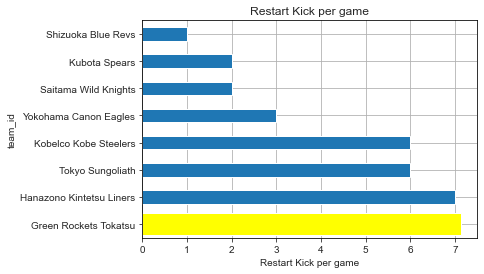

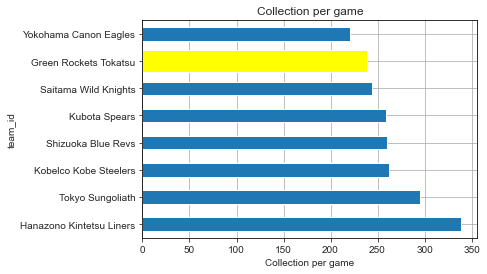

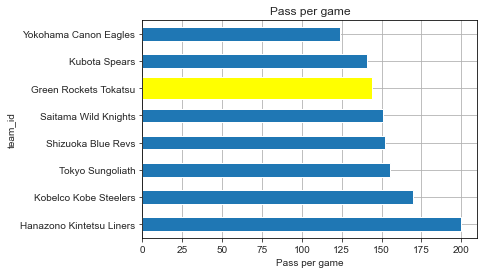

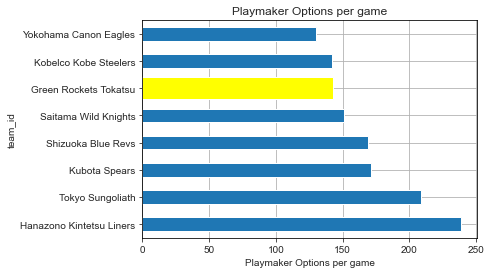

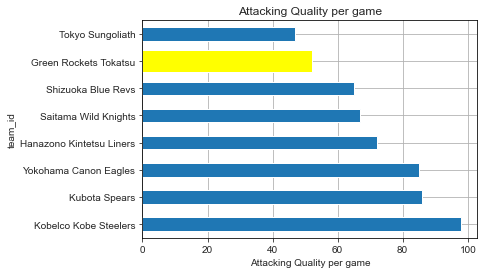

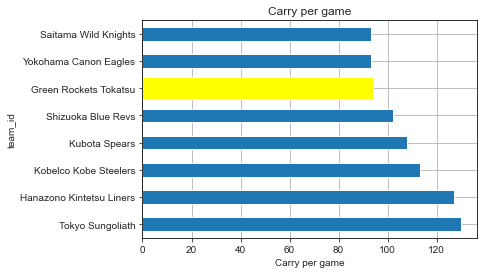

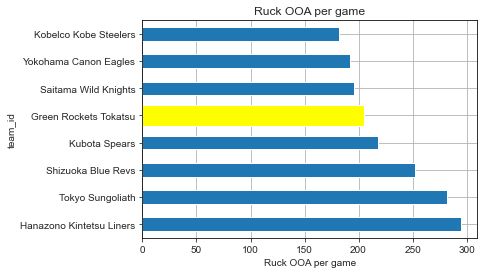

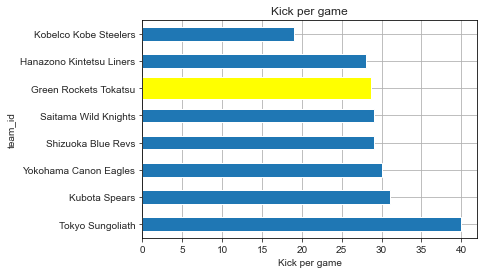

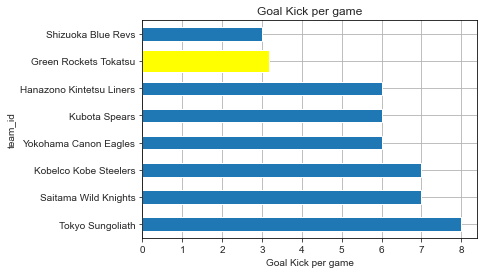

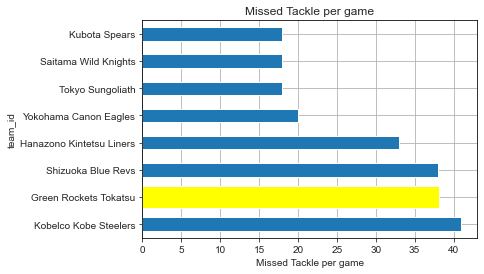

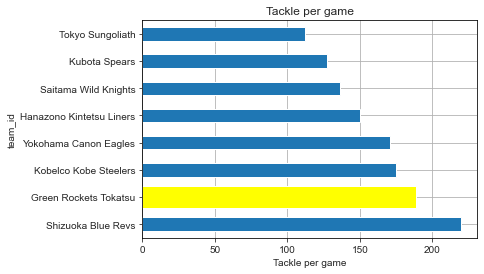

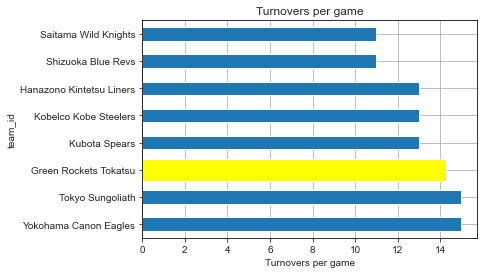

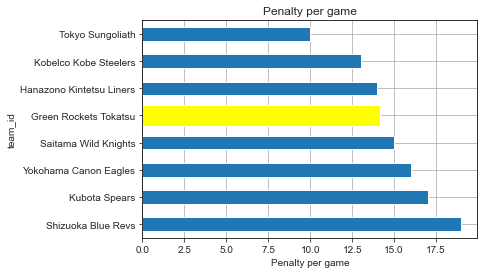

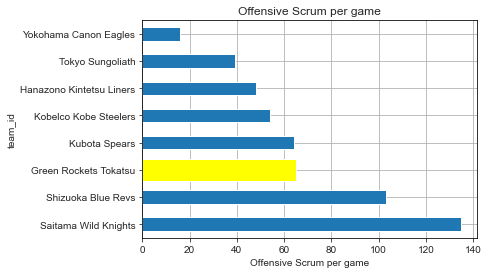

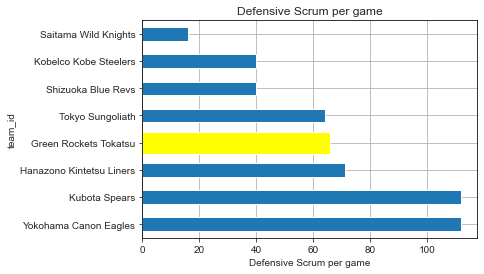

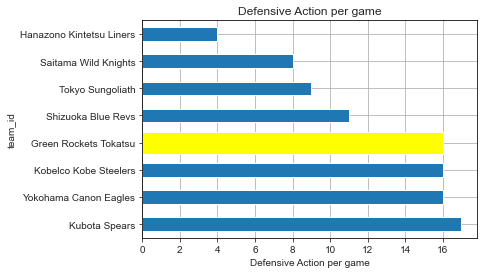

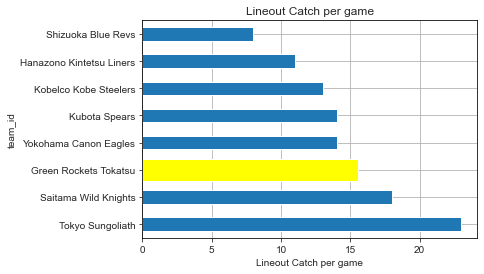

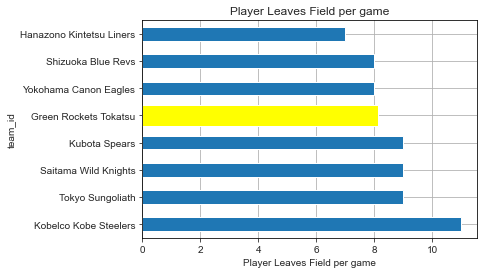

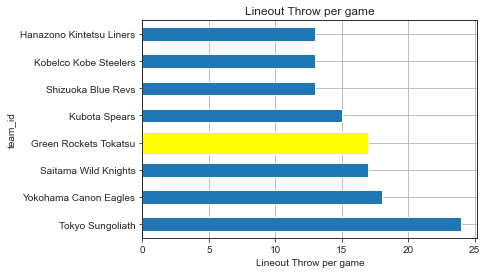

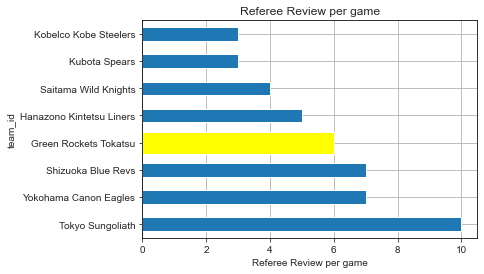

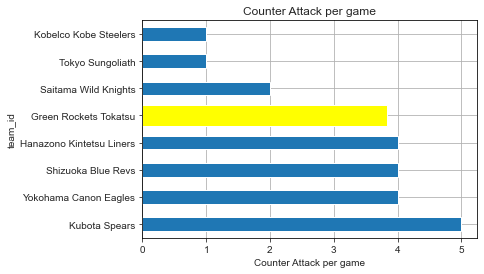

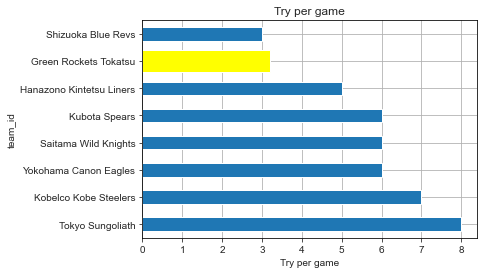

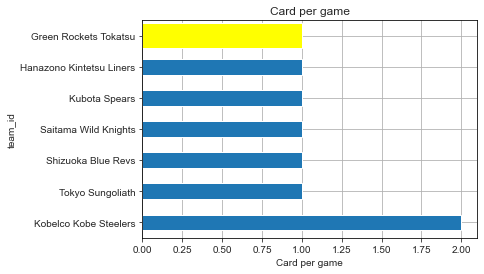

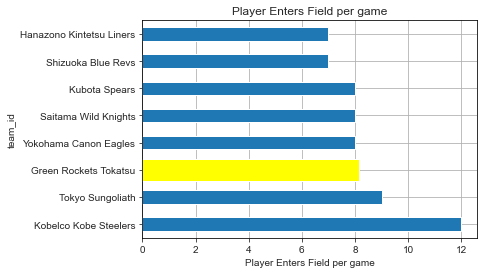

In [87]:
FILEPATH = '/Users/isakakou/Desktop/22-23_super_scout/933727_NECGvSAWK_advanced_superscout.xml'
TEAMNAME = 'Toyota Verblitz'
# パスで指定したファイルの一覧をリスト形式で取得.
directory = glob.glob('/Users/isakakou/Desktop/22-23_super_scout/*NECG*.xml')
summarize_competition(directory)
# df = read_xml(FILEPATH)
# pd_df = pd.get_dummies(df[['PLID','team_id','MatchTime','psID','period',
#                'x_coord','y_coord','x_coord_end','y_coord_end','action','ActionType','Actionresult',
#                'qualifier3','qualifier4','qualifier5','Metres','PlayNum','SetNum']])
# kick(df,TEAMNAME)
# Kubota Spears
# Green Rockets Tokatsu
# ruck_speed(df, TEAMNAME)
# carry_meter(df, TEAMNAME)
# lineout(df,TEAMNAME)
# twenty_two_entry(df,TEAMNAME)
# possession_detail(df, TEAMNAME)
# pass_table(df, TEAMNAME)
# tackle_player_table(df, TEAMNAME)
# tackle_player_table(df, TEAMNAME)
# defensive_penalty(df, TEAMNAME)
# attack_OOA(df,TEAMNAME)
# get_opponent(df, TEAMNAME)
# try_detail(df, get_opponent(df, TEAMNAME))
# plot_rucks_per_possession(df,TEAMNAME)
# tackle_detail(df, TEAMNAME)
# turnover(df,TEAMNAME)
# def kicks_from_all_game(directory, TEAMNAME)

# --------------------------------------------------------------------------
#読み込むファイルのリストを走査
# for file in directory:
#     print(file)
#     data = read_xml(file)
#     ruck_speed(data, TEAMNAME)
#     OPPONENT = get_opponent(data,TEAMNAME)
#     ruck_speed(data, OPPONENT)